# Exploration of the Heart Disease Data Set
#### Group Project Proposal 005-6

## Introduction

The dataset describes the age, sex, and other medical information about the patients that will give information on whether the patient might have heart disease or not. The last attribute gives a diagnosis of heart disease for that patient, with a value of 0 being a <50% diameter of the vessel narrowing, or a value of 1 being a >50% diameter of the vessel narrowing. This attribute uses angiographys as a way to predict and diagnose heart disease. 

The question we will try to answer is whether a patient will be diagnosed with heart disease. We have a number of predictors and we will use the technique of backward selection to narrow down our predictors to the few attributes that allow us to predict this most accurately.

We will be using the Heart Disease Data set. This database describes 76 attributes but all experiments that have been published use only 14 as a reference. The `num` column describes the presence of heart disease in the patient. The values of this field range from 0 to 4 with 0 being no presence and 1-4 a range of presence. The data set has numerous attributes related to a full medical history of the patient. These attributes include various types of information related to heart disease like chest pain, years as a smoker, family history of heart disease and other related diseases, blood sugar levels, exercise levels, and anginas (chest pain due to reduced blood flow, symptom of coronary artery disease). An angina is a very clear symptom of heart disease and has various types of anginas (as categorized by the data set with values 1, 2, 3, 4). A typical angina (value = 1) usually lasts for a few minutes and over the counter medicine can make it go away. An atypical angina (value = 2) can get worse over time and may indicate that the person is having a heart attack. A nonanginal pain (value = 3) usually results in pain similar to a normal angina however is due to different causes. Lastly, an asymptomatic angina is when there is an angina occurring, however usually little to no pain is experienced. 

## Preliminary exploratory data analysis

In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
library(MASS)
library(GGally)
library(caret)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

### Read the dataset, clean and wrangle the data into a tidy format.

Download the dataset from the url and store it into a local file.

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

download.file(url, destfile = "data/processed.cleveland.data")

Read the file into the dataframe `heart_disease_original`. We will need to manually specify the column types, which are given on the database website.

In [3]:
heart_disease_original <- read_csv("data/processed.cleveland.data",
                                   # add column names
                                   col_names = c("age",
                                                 "sex",
                                                 "cp", 
                                                 "trestbps", 
                                                 "chol", 
                                                 "fbs", 
                                                 "restecg", 
                                                 "thalach", 
                                                 "exang", 
                                                 "oldpeak", 
                                                 "slope", 
                                                 "ca", 
                                                 "thal", 
                                                 "num"))

head(heart_disease_original, 10)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,0,4,120,354,0,0,163,1,0.6,1,0.0,3.0,0
63,1,4,130,254,0,2,147,0,1.4,2,1.0,7.0,2
53,1,4,140,203,1,2,155,1,3.1,3,0.0,7.0,1


It looks like R read the columns `ca` and `thal` as characters due to the values involving decimals. Let's take a closer look at these columns.

We want to find whether there is a use for these decimal values. That is, we want to see whether all `ca` and `thal` values are `x.0` where `x` is a digit, or if there are other digits except for 0 after the decimal

In [4]:
heart_disease_original |> 
    dplyr::select(ca, thal) |> 
    filter(grepl("[0-9].[1-9]", ca) |
           grepl("[0-9].[1-9]", thal))

ca,thal
<chr>,<chr>


Note that we needed to specify we want to use the `dplyr` library because the `select` function is masked.

Anyways, we selected `ca` and `thal` and then filtered it using regex to find whether there was ever a case in these two columns where the pattern `[0-9].[1-9]` returned true. What this pattern basically means is we want to check if there was a digit (between 0 and 9) followed by any character followed by a digit (between 1 and 9). 

Since we did not get any results, we know that all digits after the decimal in `ca` and `thal` are followed by 0. Therefore, it's ok if we convert these columns to an integer and we won't lose any information


Now, we need to wrangle `heart_disease_original` by removing all rows that contain a question mark, filtering essentially NA values and changing the type of `ca` and `thal` to be an integer.

In [5]:
heart_disease <- heart_disease_original |> 

                    # remove all rows that contain a question
                    # mark (esentially NA values) to supress
                    # warnings from R
                    filter(thal != "?", ca != "?") |>

                    # change columns ca and thal to be numeric
                    # to allow for tidymodels to work properly
                    mutate(ca = as.numeric(ca),
                          thal = as.numeric(thal)) |>

                    # remove rows with NA values
                    na.omit()     

head(heart_disease, 10)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,0,4,120,354,0,0,163,1,0.6,1,0,3,0
63,1,4,130,254,0,2,147,0,1.4,2,1,7,2
53,1,4,140,203,1,2,155,1,3.1,3,0,7,1


Let's check the distribution for our target variable `num`. 

In [6]:
(sum_of_rows <- nrow(heart_disease))

heart_disease |> 
   group_by(num) |> 
   summarize(count = n()) |>
   mutate(percent = 100 * (count/sum_of_rows))

[1] 297

num,count,percent
<dbl>,<int>,<dbl>
0,160,53.872054
1,54,18.181818
2,35,11.784512
3,35,11.784512
4,13,4.377104


It looks like there is an uneven proportion of data where `num` = 1, 2, 3 or 4. Due to the lack of distribution of data, we will likely not get a very accurate k-nn model. We will solve this problem later by upsampling our training data. For now, let's continue as normal. 

Firtly, we will change the `num` column to be of type factor.

In [7]:
# change type of num
heart_disease <- heart_disease |>
    mutate(num = as_factor(num))

### Split the dataset into training set and testing set.

We will split our dataset `heart_diease` into a testing and training set. We will upsample the training set which will hopefully increase the accuracy of our model.

In [40]:
# setting a seed which will not be changed for the rest of the project
set.seed(2000)

heart_disease_split <- initial_split(heart_disease, prop = 0.75, strata = num)
heart_disease_training <- training(heart_disease_split)
heart_disease_testing <- testing(heart_disease_split)

head(heart_disease_training)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
41,0,2,130,204,0,2,172,0,1.4,1,0,3,0
56,1,2,120,236,0,0,178,0,0.8,1,0,3,0
57,0,4,120,354,0,0,163,1,0.6,1,0,3,0
57,1,4,140,192,0,0,148,0,0.4,2,0,6,0


Now, we will use the `upSample` function from `caret` to upsample all the minority classes in `heart_disease_training` to have the same amount of observations as the majority class. 

In [41]:
heart_disease_training_upsampled <- upSample(x = heart_disease_training[,-ncol(heart_disease_training)],
                                             y = heart_disease_training$num) |>
                                    # upSample changes the name of the column of the factor variable to
                                    # Class so we will change it back to num manually
                                    mutate(num = Class) |>
                                    dplyr::select(-Class)

head(heart_disease_training_upsampled)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
2,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
3,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0
4,56,1,2,120,236,0,0,178,0,0.8,1,0,3,0
5,57,0,4,120,354,0,0,163,1,0.6,1,0,3,0
6,57,1,4,140,192,0,0,148,0,0.4,2,0,6,0


In [42]:
heart_disease_training |> 
   group_by(num) |> 
   summarize(count = n()) |>
   mutate(percent = 100 * (count/nrow(heart_disease_training)))

heart_disease_training_upsampled |> 
   group_by(num) |> 
   summarize(count = n()) |>
   mutate(percent = 100 * (count/nrow(heart_disease_training_upsampled)))

num,count,percent
<fct>,<int>,<dbl>
0,120,54.298643
1,40,18.099548
2,26,11.764706
3,26,11.764706
4,9,4.072398


num,count,percent
<fct>,<int>,<dbl>
0,120,20
1,120,20
2,120,20
3,120,20
4,120,20


age: age in years

sex: sex (1 = male; 0 = female)

cp: chest pain type

* Value 1: typical angina

* Value 2: atypical angina

* Value 3: non-anginal pain

* Value 4: asymptomatic

trestbps: resting blood pressure (in mm Hg on admission to the hospital)

chol: serum cholestoral in mg/dl

fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)

restecg: resting electrocardiographic results

thalach: maximum heart rate achieved

exang: exercise induced angina (1 = yes; 0 = no)

oldpeak = ST depression induced by exercise relative to rest

slope: the slope of the peak exercise ST segment

* Value 1: upsloping

* Value 2: flat

* Value 3: downsloping

ca: number of major vessels (0-3) colored by flourosopy

thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

num: diagnosis of heart disease (angiographic disease status)

* Value 0: < 50% diameter narrowing

* Value 1: > 50% diameter narrowing


Section 6.8.3 of the data science textbook briefly mentions the method of forward selection in R. However, the method it shows is far too manual. The more manual we make our program, the more prone it is to errors. Therefore, we will be using the `MASS` library to import a few functions which allow us to do the same thing.

We have 14 predictors and, given our limited biology knowledge, we can't seem to easily dismiss any predictors that would have no correlation with the presence of heart disease. Therefore, instead of forward selection, we will use backward selection to remove one predictor at a time. Then, we will check if the `AIC` of the new model goes down. We will remove the predictor which lowers the `AIC` the most until we get to a point where removing predictors increases `AIC`. 

In [43]:
# the MASS library requires all values to be an integer
heart_disease_training_aic <- heart_disease_training |>
    mutate(num = as.numeric(num))

In [44]:
# null <- lm(num ~ 1, data = heart_disease_training_aic) # 1 means no predictor 
# full <- lm(num ~ ., data = heart_disease_training_aic) # use all predictors
 
# # this function goes from full (all predictors) to null (no predictors) 
# # and removes the predictor whose removal decreases the AIC the most
# stepAIC(full, scope = list(lower = null, upper=full), 
#          data = heart_disease_training_aic,
#          direction='backward')

Looking at the output of `stepAIC`, it looks like it suggests that sex, cp, exang, oldpeak, slope, ca, and thal are the predictors which we should use before we start losing accuracy. 


# Visualization to confirm findings

To confirm our predictor variables, we will use `ggpairs` to find the correlation between all the variables and our factor variable `num`. However, since we have a lot of predictor variables, to make it easy to view 14 different graphs, we will break our dataset into 2 smaller datasets and view them seperately to make it more legible.

In [45]:
heart_disease_training_1 <- heart_disease_training_upsampled |>
    # select the first 7 columns as well as num 
    dplyr::select(1:7, num)

heart_disease_training_2 <- heart_disease_training_upsampled |>
    # select the remaining columns
    dplyr::select(8:14)

head(heart_disease_training_1)
head(heart_disease_training_2)

,age,sex,cp,trestbps,chol,fbs,restecg,num
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,63,1,1,145,233,1,2,0
2,37,1,3,130,250,0,0,0
3,41,0,2,130,204,0,2,0
4,56,1,2,120,236,0,0,0
5,57,0,4,120,354,0,0,0
6,57,1,4,140,192,0,0,0


,thalach,exang,oldpeak,slope,ca,thal,num
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,150,0,2.3,3,0,6,0
2,187,0,3.5,3,0,3,0
3,172,0,1.4,1,0,3,0
4,178,0,0.8,1,0,3,0
5,163,1,0.6,1,0,3,0
6,148,0,0.4,2,0,6,0


In [46]:
big_plot_1 <- ggpairs(heart_disease_training_1, 
                      # make the text size bigger 
                      upper = list(continuous = wrap("cor", size = 10)),
                      # color the output by our factor variable and make
                      # the graphs translucent
                      ggplot2::aes(colour = num, alpha = 0.5))

big_plot_2 <- ggpairs(heart_disease_training_2, 
                      # make the text size bigger 
                      upper = list(continuous = wrap("cor", size = 10)),
                      # color the output by our factor variable and make
                      # the graphs translucent
                      ggplot2::aes(colour = num, alpha = 0.5))

Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin(

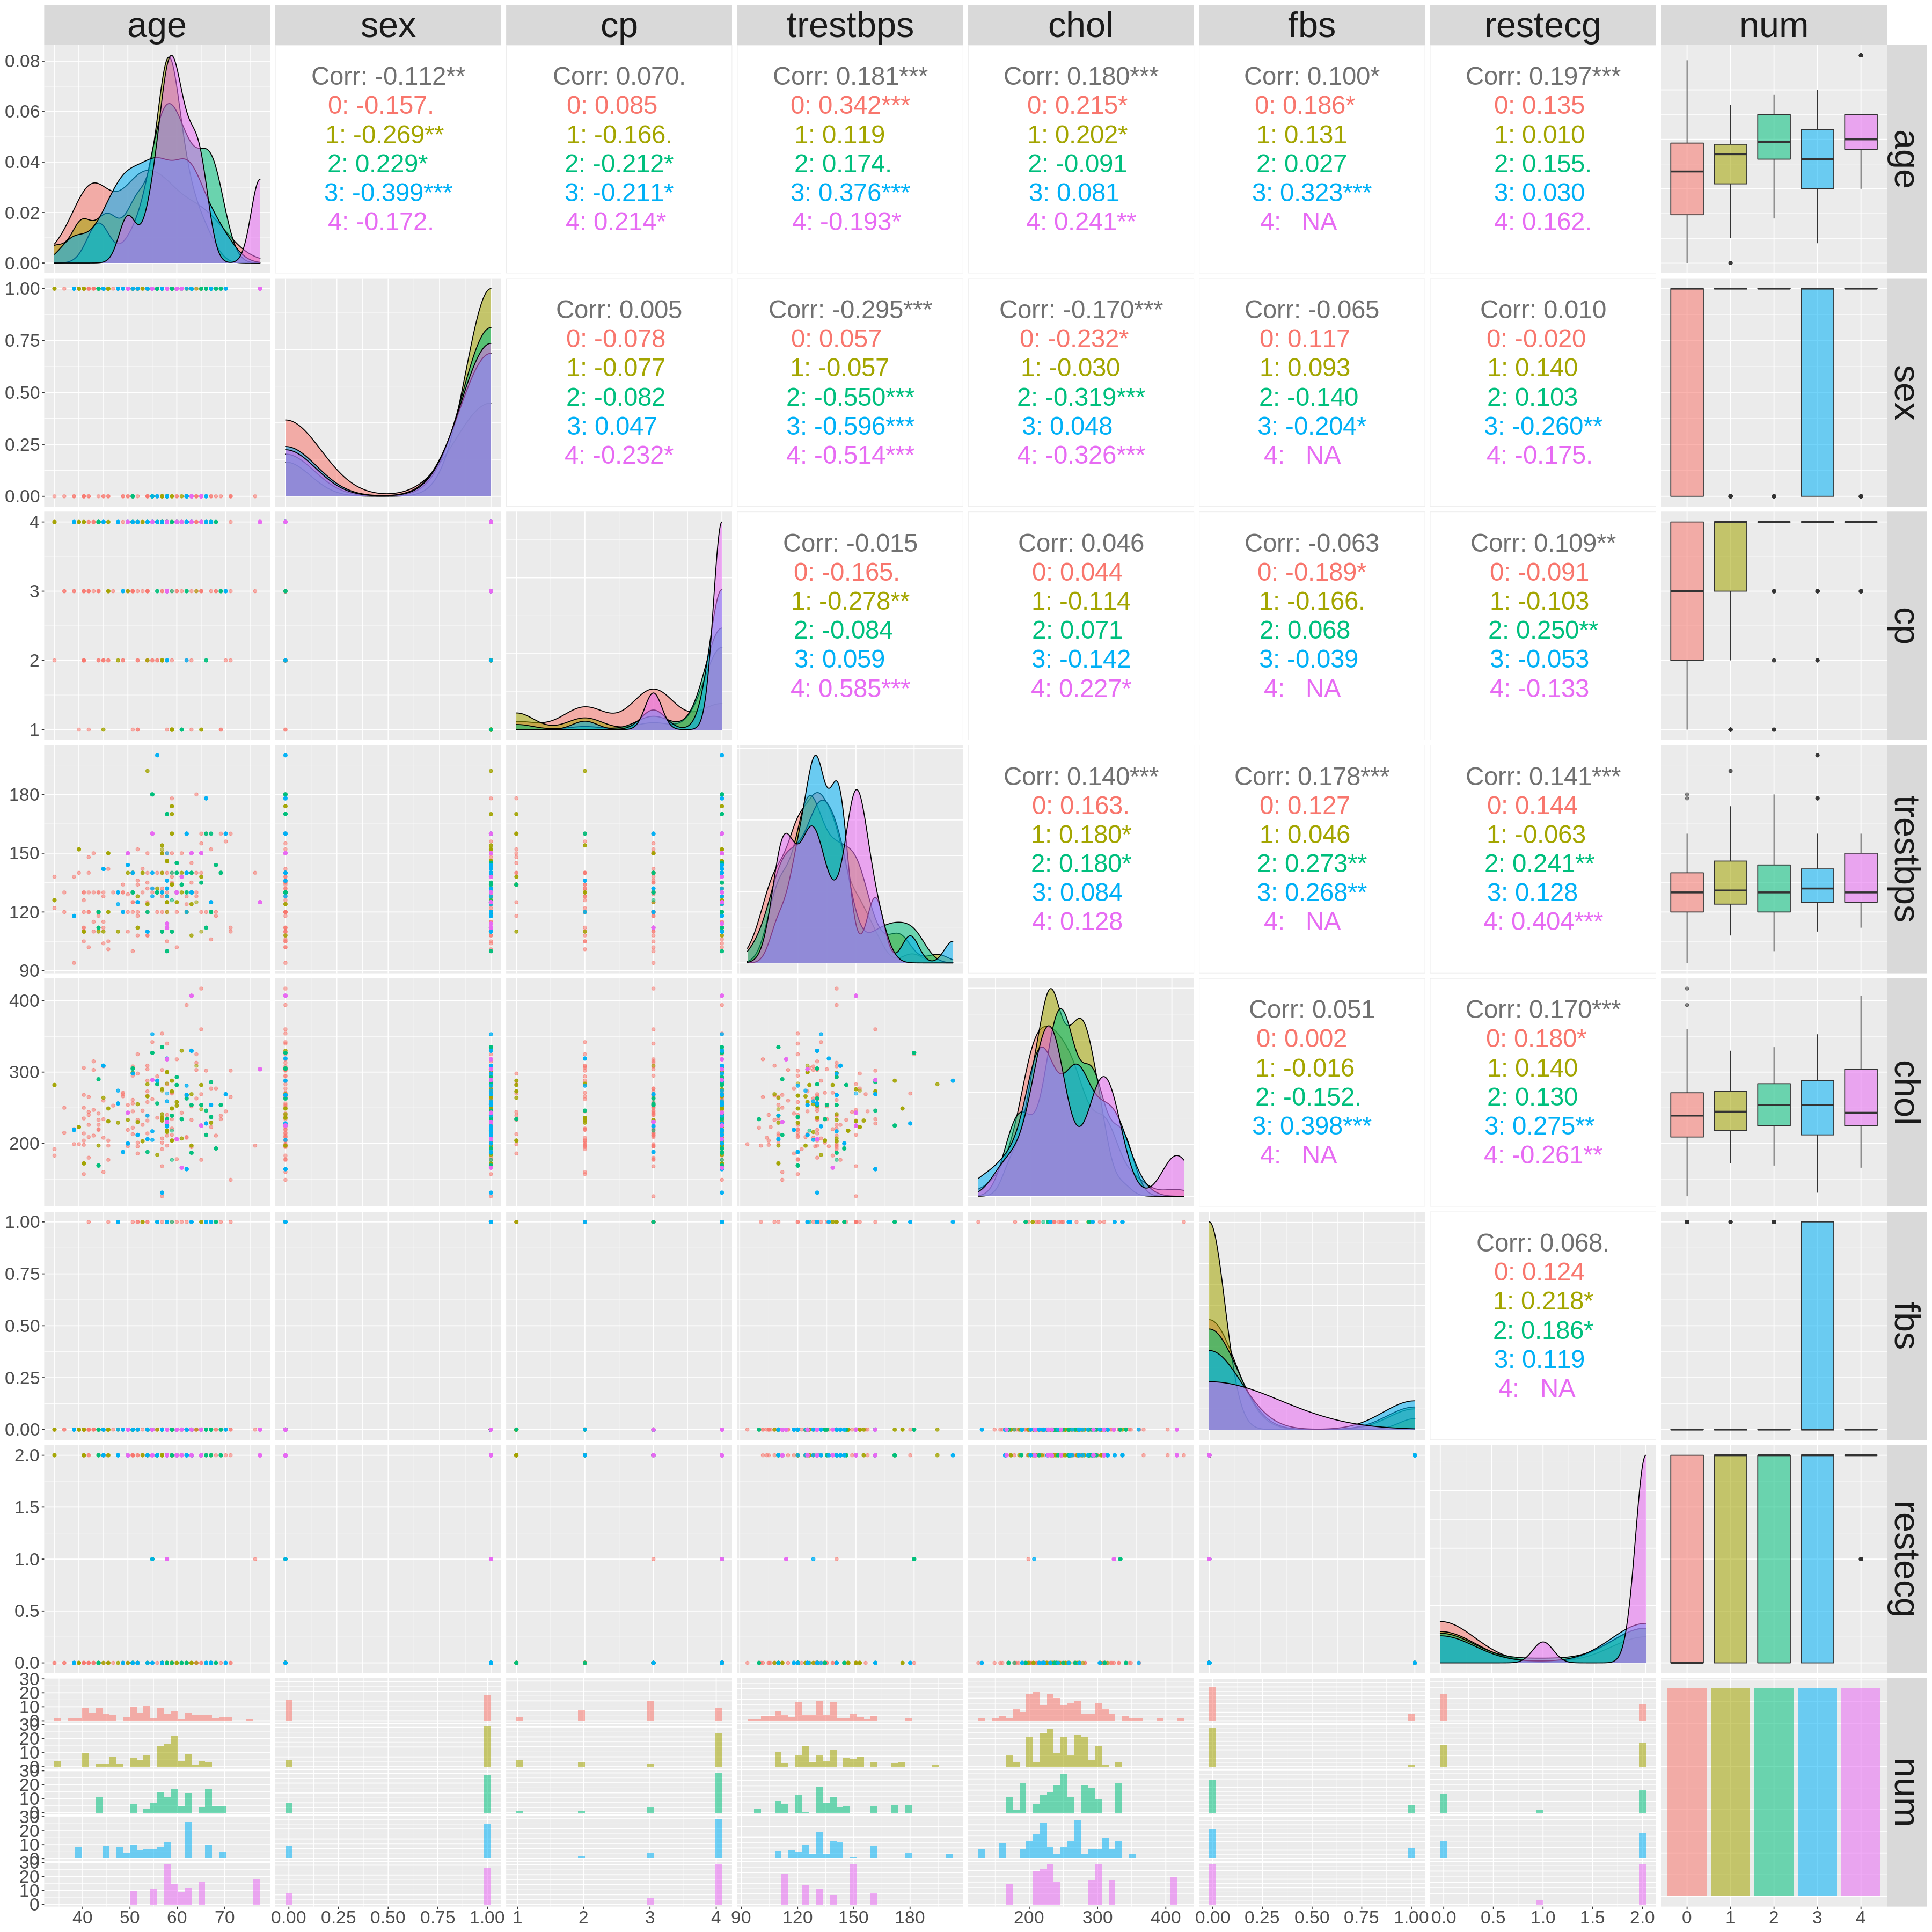

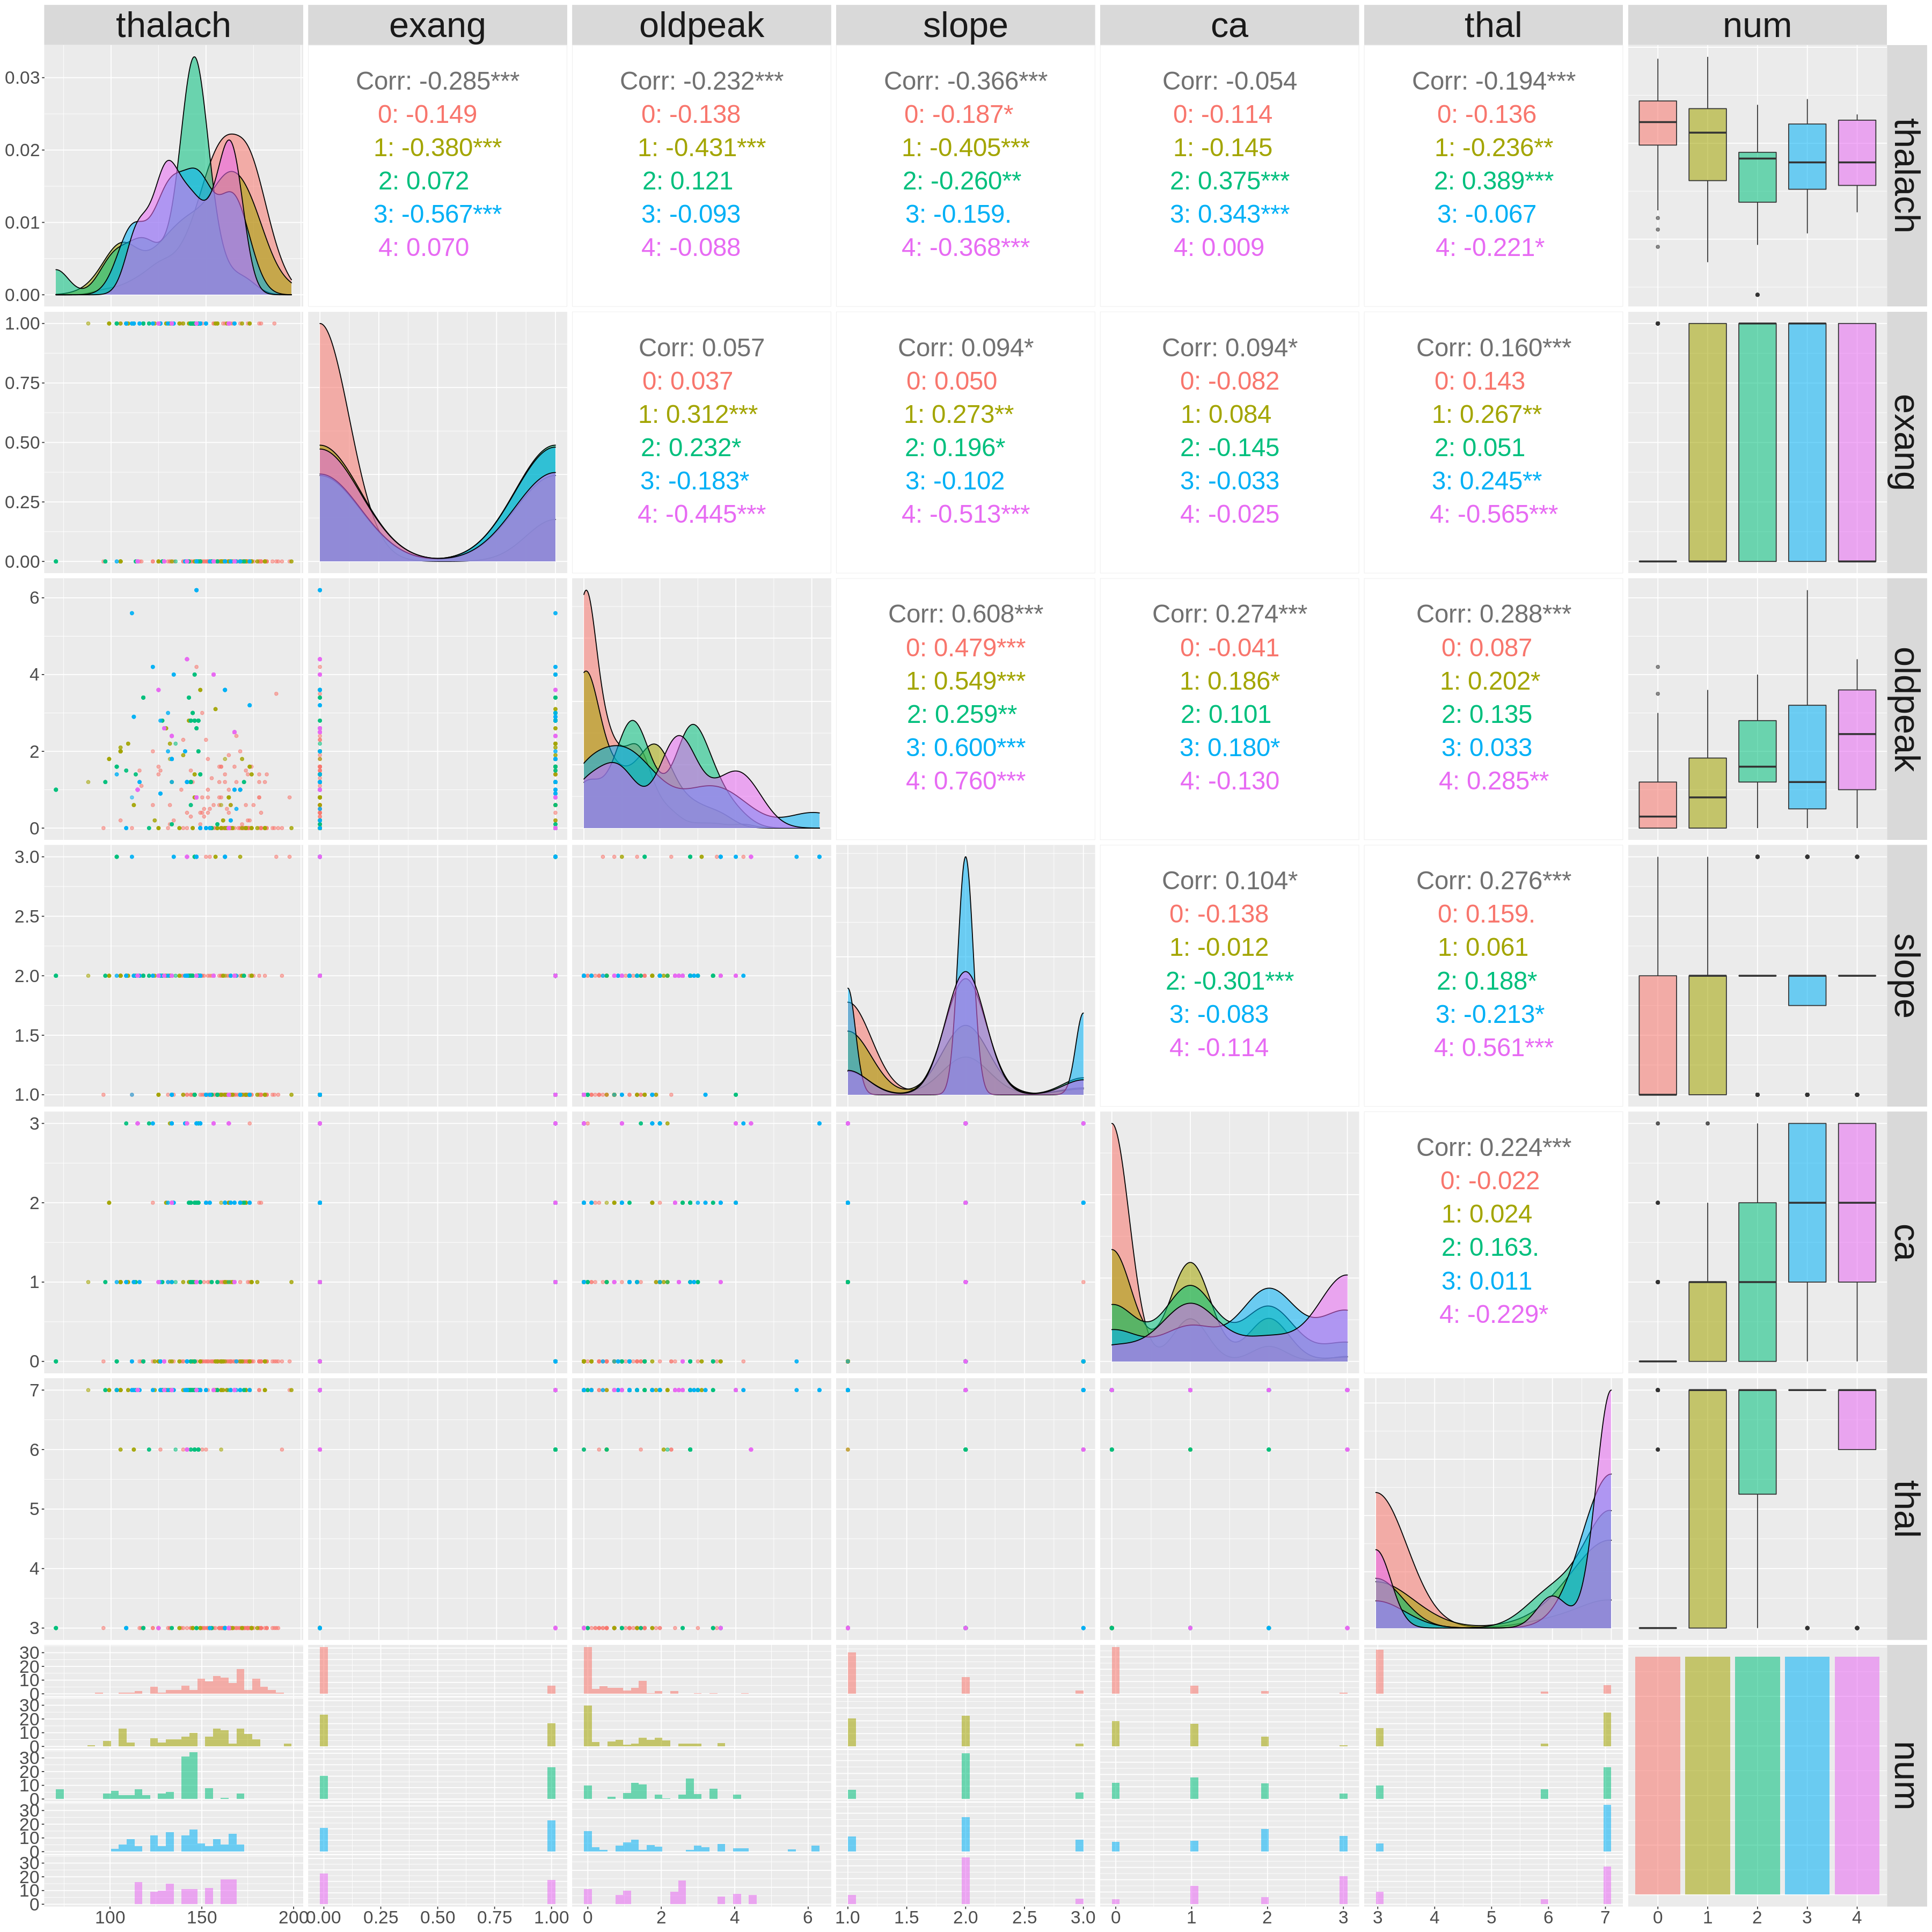

In [47]:
options(repr.plot.width = 30, repr.plot.height = 30)
 
big_plot_1 + # make all text bigger
             theme(text = element_text(size = 50), 
                   # adjust the axis text to be a bit smaller 
                   axis.text = element_text(size = 20))

big_plot_2 + # make all text bigger
             theme(text = element_text(size = 50), 
                   # adjust the axis text to be a bit smaller 
                   axis.text = element_text(size = 20))

We will only focus on the diagonal line of these two graphs. Basically, what we want to do is see for which variable is there a stark difference between the blue and the red curve, indicating that this variable is significant for determining the presence of heart disease.

We can see that there is a sharp blue peak which varies from the red curve for the `sex` variable. Therefore, this variable will be useful to determine the presence of heart disease and we should include it as our predictor.

Other variables where we see a noticeable difference between the blue and red curves include `cp`, `thalach`, `exang`, `oldpeak`, `slope`, `ca`, and `thal`. Note that with the exception of `oldpeak`, all of these predictor variables were given to us by the `stepAIC` function in the previous step. Looking at the graph, it does look like `oldpeak` would be a valuable inclusion as a predictor since it seems to distinguish very well between the two curves at low values and it's moderately effective at detecting the presence of heart disease at higher values.

### Using only training data, summarize the data in one table.

Since we don't know the best value of $k$ to use for the model, we will use `vfold` and the `tune()` function to determine the accuracy of the model at different values of $k$. Firstly, we will create the recipe.

In [48]:
# create recipe for k-nn using the previously mentioned predictors
heart_disease_recipe <- recipe(num ~ age + cp + trestbps + chol + thalach + oldpeak + slope + ca + thal,
                               data = heart_disease_training_upsampled) |>
                        # normalize data
                        step_scale(all_predictors()) |>
                        step_center(all_predictors())

We will start the $k$ value at 1 and set the upper limit to 160. We chose the upper limit of 160 since that is the count of the majority factor (there are 160 rows with a `num` value of 0). Therefore, any higher than this will result in the value of the majority classifier. 

In [63]:
# we will use a step value of 5 to provide high accuracy while not severly effecting
# computation speed
k_vals <- tibble(neighbors = seq(from = 5, to = 70, by = 10))

# create a standard 5 fold model of the training data
heart_disease_vfold <- vfold_cv(heart_disease_training_upsampled, v = 5, strata = num)

# create the specification of our k-nn model using tune() for the neighbours value
heart_disease_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                 set_engine("kknn") |>
                 set_mode("classification")


heart_disease_tune_results <- workflow() |>
  add_recipe(heart_disease_recipe) |>
  add_model(heart_disease_tune) |>
  tune_grid(resamples = heart_disease_vfold, grid = k_vals) |>
  collect_metrics() 

accuracies <- heart_disease_tune_results |>
  filter(.metric == "accuracy") |>
  arrange(desc(mean))

accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
5,accuracy,multiclass,0.8100000,5,0.01545603,Preprocessor1_Model1
15,accuracy,multiclass,0.6383333,5,0.01550090,Preprocessor1_Model2
25,accuracy,multiclass,0.5450000,5,0.01252775,Preprocessor1_Model3
⋮,⋮,⋮,⋮,⋮,⋮,⋮
45,accuracy,multiclass,0.4716667,5,0.01947220,Preprocessor1_Model5
55,accuracy,multiclass,0.4466667,5,0.02134375,Preprocessor1_Model6
65,accuracy,multiclass,0.4250000,5,0.02457980,Preprocessor1_Model7


[1] 5

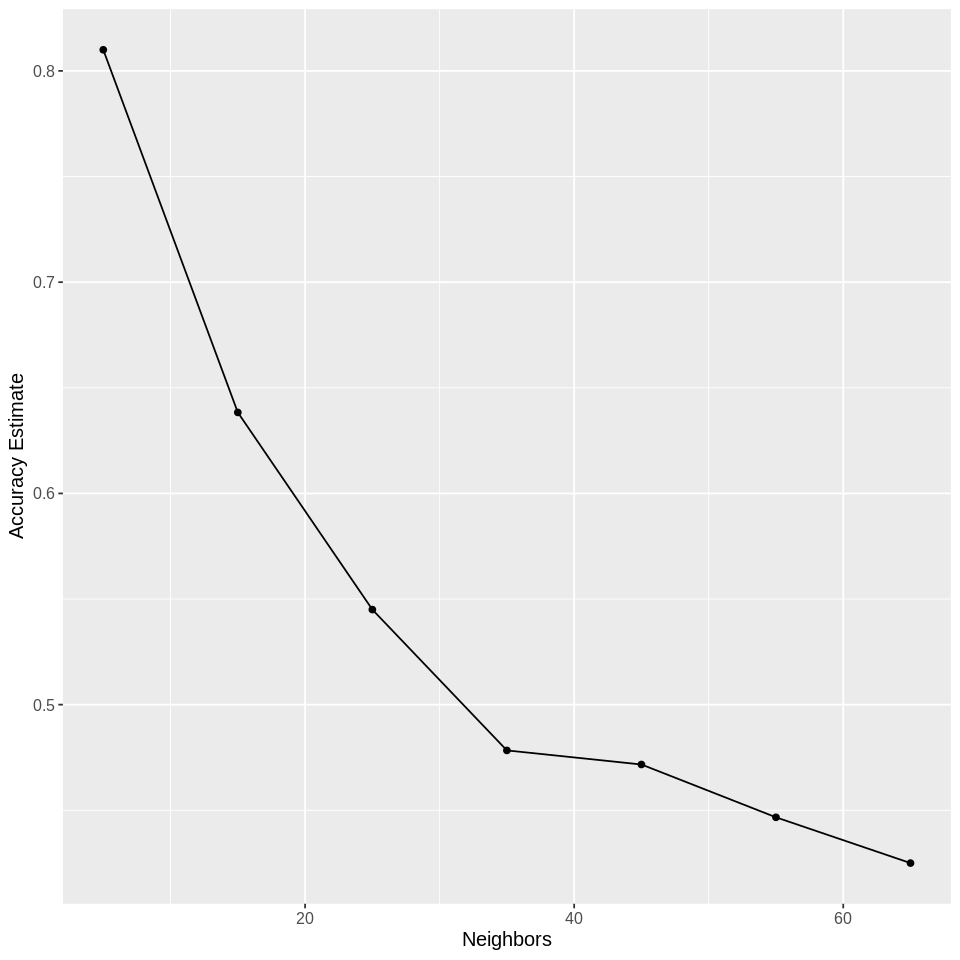

In [64]:
(min_k_value <- accuracies |>
    dplyr::select(neighbors) |>
    slice(1) |>
    pull())

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12))

accuracy_vs_k

In [67]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = 11
                        ) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(heart_disease_recipe) |>
  add_model(knn_spec) |>
  fit(data = heart_disease_training)

In [68]:
(heart_disease_test_predictions <- predict(knn_fit, heart_disease_testing) |>
  bind_cols(heart_disease_testing))

heart_disease_test_predictions |>
  metrics(truth = num, estimate = .pred_class) |>
  filter(.metric == "accuracy")

heart_disease_test_predictions

.pred_class,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0,44,1,2,120,263,0,0,173,0,0.0,1,0,7,0
0,52,1,3,172,199,1,0,162,0,0.5,1,0,7,0
0,48,0,3,130,275,0,0,139,0,0.2,1,0,3,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0,56,1,2,120,240,0,0,169,0,0.0,3,0,3,0
0,67,1,3,152,212,0,2,150,0,0.8,2,0,7,1
1,59,1,4,164,176,1,2,90,0,1.0,2,2,6,3


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.6052632


.pred_class,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0,44,1,2,120,263,0,0,173,0,0.0,1,0,7,0
0,52,1,3,172,199,1,0,162,0,0.5,1,0,7,0
0,48,0,3,130,275,0,0,139,0,0.2,1,0,3,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0,56,1,2,120,240,0,0,169,0,0.0,3,0,3,0
0,67,1,3,152,212,0,2,150,0,0.8,2,0,7,1
1,59,1,4,164,176,1,2,90,0,1.0,2,2,6,3


          Truth
Prediction  0  1  2  3  4
         0 39 13  1  5  2
         1  0  0  4  2  1
         2  1  1  4  1  1
         3  0  0  0  1  0
         4  0  0  0  0  0

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



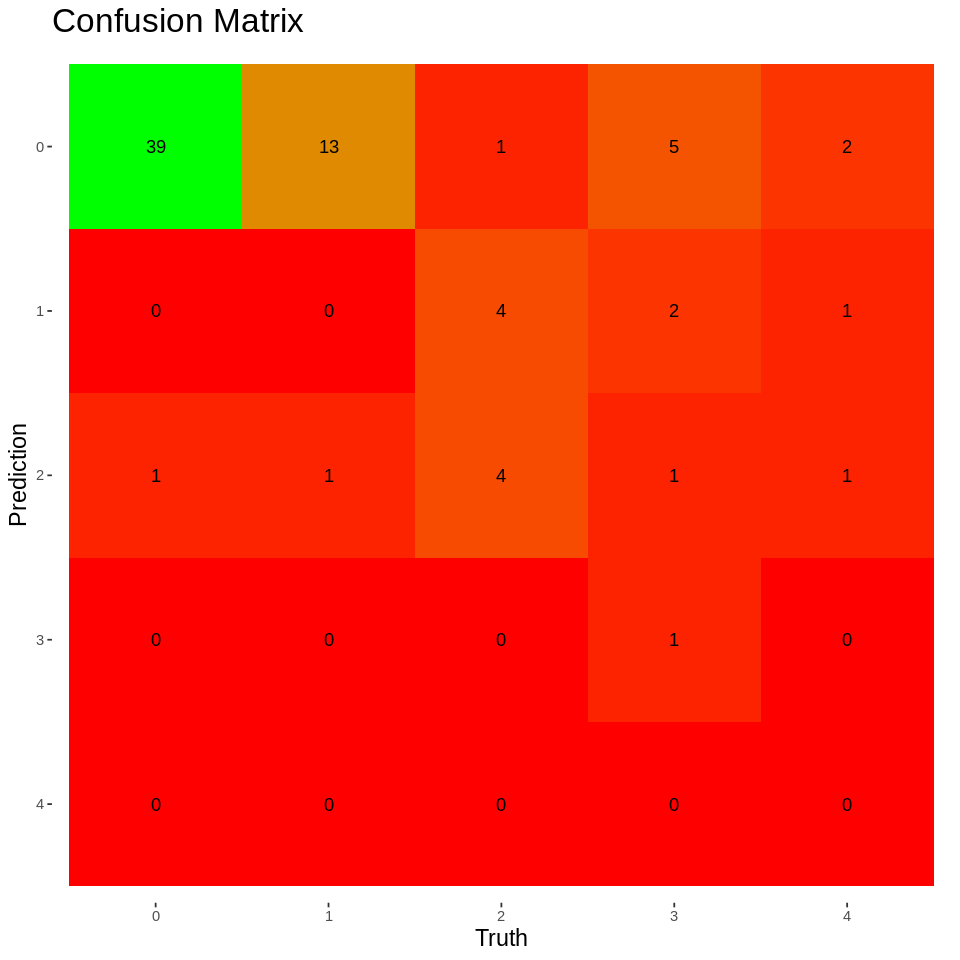

In [53]:
options(repr.plot.width = 8, repr.plot.height = 8)

(confusion <- heart_disease_test_predictions |>
             conf_mat(truth = num, estimate = .pred_class))

autoplot(confusion, type = "heatmap") +
  scale_fill_gradient(low = "red", high = "green") +
  ggtitle("Confusion Matrix") +
  # make all text bigger
  theme(
      axis.title.x = element_text(size = 14),
      axis.title.y = element_text(size = 14),
      plot.title = element_text(size = 20)
  )

In [54]:
(sum_of_rows <- nrow(heart_disease_training))

heart_disease_training |> 
   group_by(num) |> 
   summarize(count = n()) |>
   mutate(percent = 100 * (count/sum_of_rows))

[1] 221

num,count,percent
<fct>,<int>,<dbl>
0,120,54.298643
1,40,18.099548
2,26,11.764706
3,26,11.764706
4,9,4.072398


### Using only training data, visualize the data with a plot.

Plot the data with age, maximum heart rate achieved and sex.

## Methods

sex + cp + exang + oldpeak + slope + ca + thal

- Explain how you will conduct either your data analysis and which variables/columns you will use. Note - you do not need to use all variables/columns that exist in the raw data set. In fact, that's often not a good idea. For each variable think: is this a useful variable for prediction?

We will try and use k-nn regression using the indicators of age and maximum heart rate achieved with `num` to see if we can predict the presence of heart disease using the indicators. We will also compare the results between the two sexes to see if these indicators work well with a certain sex or not.

- Describe at least one way that you will visualize the results

We will use scatter plots to visualize our result. We would also use a heat map to visualize our confusion matrices for different values of $K$. 

## Expected outcomes and significance

- What do you expect to find?
- What impact could such findings have?
- What future questions could this lead to?

  We expect to find information pointing towards the best range of conditions individuals should be in to avoid heart diseases. Our findings will show how likely a patient will be diagnosed with a heart disease based on the variables presented. These findings could be used to convey health care information towards the general public. Health care professionals can also use these findings to provide better care and diagnosis. Thereby improving the quality of life for patients of all different backgrounds. These findings could lead to questions about the best way to take care of your heart and future medical innovations. 


# References

* https://datasciencebook.ca/

* https://advstats.psychstat.org/book/mregression/selection.php

* https://rdrr.io/cran/GGally/man/ggpairs.html

* https://www.youtube.com/watch?v=0aTtMJO-pE4

* https://stackoverflow.com/a/50710989

* https://www.rdocumentation.org/packages/base/versions/3.6.2/topics/grep

* https://ggplot2.tidyverse.org/reference/theme.html

* An Introduction to Statistical Learning (James et al. 2013)